In [1]:
import sys
sys.path.append(r'/home1/roeyshafran/BrainCap/Mind-Cap/code/Mind_Vis_utils/')

from fmri_caption import GPTCaptionModel, create_fmri_encoder_from_pretrained,top_k_top_p_filtering, set_parameter_requires_grad
from dataset import create_BOLD5000_dataset
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import heapq
#import optuna
%matplotlib inline

#### Setup

In [2]:
# Parameters
BATCH_SIZE = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
TRIAL_NUM_TRAIN_EXAMPLES = BATCH_SIZE*30
TRIAL_NUM_VAL_EXAMPLES = BATCH_SIZE*10
WARMUP_STEPS = 2000

cuda:0


In [3]:
# Pretrained files
path_fmri_encoder = r"/databases/roeyshafran/BrainCap/pretrains/pretrain_metafile.pth"
path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/BOLD5000/CSI1_dataset.pth"

# create BOLD5000 dataset
BOLD_dataset = torch.load(path_BOLD_dataset)
bold_train, bold_test = BOLD_dataset['train'], BOLD_dataset['test']


In [4]:
test_idx, val_idx = train_test_split(list(range(len(bold_test))),test_size=0.5)
bold_val = Subset(bold_test, val_idx)
bold_test = Subset(bold_test, test_idx)

train_dl = DataLoader(bold_train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(bold_val, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(bold_test, batch_size=BATCH_SIZE, shuffle=True)


#### Function Delerations

In [313]:
@torch.no_grad()
def calculate_semantic_similarity(generated_caption, real_caption, device):
    sentence_model = SentenceTransformer('all-mpnet-base-v2').to(device)
    embed_generated = sentence_model.encode(generated_caption, convert_to_tensor=True)
    embed_real_caption = sentence_model.encode(real_caption, convert_to_tensor=True)
      
    return torch.diagonal(util.pytorch_cos_sim(embed_generated, embed_real_caption))

def define_GPTCaption_model(encoder, trial=None, projection_sizes=None):
    if trial:
        # TODO: Add Optuna support. If trial is used, override projection_sizes with Optuna suggestion
        num_layers = trial.suggest_int("num_projection_layers", 1, 5)
        projection_sizes = [encoder.embed_dim]*num_layers
    gpt_decoder = GPTCaptionModel(encoder.num_patches, encoder.embed_dim, projection_sizes)
    set_parameter_requires_grad(gpt_decoder.embedding_space_projection, feature_extraction=False)
    set_parameter_requires_grad(gpt_decoder.gpt, feature_extraction=True)
    #set_parameter_requires_grad(gpt_decoder.tokenizer, feature_extraction=True)
    #for param in gpt_decoder.tokenizer.parameters():
    #  param.requires_grad = False

    return gpt_decoder

def print_batch(batch, fontsize=5, num_of_columns=5, caption_as_title=False):
    N = int(np.ceil(np.sqrt(len(batch))))
    num_of_plots = len(batch)
    num_of_rows = num_of_plots // num_of_columns
    fig, axs = plt.subplots(num_of_rows, num_of_columns)
    if hasattr(axs, '__iter__'):
        axs = axs.flatten()
    else:
        axs = [axs]
    for idx, ax in enumerate(axs):
        try:
            ax.imshow(batch[idx]['image'])
            str_to_show = f"({idx}) Generated: {batch[idx]['caption']}\n   Real: {batch[idx]['real_caption']}  Accuracy: {batch[idx]['accuracy']}"
            if caption_as_title:
                ax.set_title(str_to_show, fontsize=fontsize)
            else:
                print(str_to_show)
        except IndexError:
            pass
        ax.set_xticks([],[])
        ax.set_yticks([],[])
      
    fig.tight_layout()




def calculate_accuracy_on_test(encoder, decoder, dataloader, device, return_best_batch=False):
    running_accuracy = 0
    best_accuracy = 0
    for batch in dataloader:
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch['caption'], device)).item()
        running_accuracy += accuracy
        if return_best_batch and (accuracy > best_accuracy):
            best_accuracy = accuracy
            fields = ['accuracy', 'caption', 'real_caption', 'image']
            best_batch = [dict(zip(fields, t)) for t in zip(accuracy, generated_caption, batch['caption'], batch['image'])]
            #best_batch = list(zip(generated_caption, batch['caption'], batch['image']))
    
    if return_best_batch:
        return running_accuracy / len(dataloader), best_batch
    else:
        return running_accuracy / len(dataloader)
        
def get_k_best(encoder, decoder, dataloader, k, device):
    k_best = []
    for batch in dataloader:
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, k_best) # in-place
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        acc = calculate_semantic_similarity(generated_caption, batch['caption'], device).tolist()
        fields = ['accuracy', 'caption', 'real_caption', 'image', 'fmri']
        d = [dict(zip(fields, t)) for t in zip(acc, generated_caption, batch['caption'], batch['image'], batch['fmri'])] # list of {'accuracy':accuracy, 'generated':generated caption, 'real': labeled caption}
        d.extend(k_best)
        k_best = heapq.nlargest(k, d, key=lambda s:s['accuracy'])

    return k_best

def remove_previously_seen_fmri(batch, k_best):
    # Works in-line
    k_best_fmri = torch.tensor([]) if not k_best else torch.cat([torch.unsqueeze(s['fmri'], dim=0) for s in k_best], dim=0)
    duplicated_mask = torch.isin(batch['fmri'], k_best_fmri)[:, 0, 0]
    duplicated_mask = ~duplicated_mask
    batch['fmri'] = batch['fmri'][duplicated_mask]
    batch['image'] = batch['image'][duplicated_mask]
    batch['caption'] = batch['caption'][duplicated_mask]

    return


def remove_duplicates_in_batch(batch):
    # Works in-place
    unique_fmri, idx = unique(batch['fmri'], dim=0)
    batch['fmri'] = unique_fmri
    batch['image']  = torch.index_select(batch['image'], dim=0, index=idx)
    batch['caption'] = np.array(batch['caption'])[idx]

    return
    

def unique(x, dim=-1):
    unique, inverse = torch.unique(x, return_inverse=True, dim=dim)
    perm = torch.arange(inverse.size(dim), dtype=inverse.dtype, device=inverse.device)
    inverse, perm = inverse.flip([dim]), perm.flip([dim])
    return unique, inverse.new_empty(unique.size(dim)).scatter_(dim, inverse, perm)

def objective(encoder, decoder, train_dl, val_dl, device, trial=None):

    # Generate the optimizers
    if trial:
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer_name = trial.suggest_categorial("optimizer", ['Adam', 'AdamW', "SGD"])
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr)
        batch_size = trial.suggest_int("batch_size", 1, 10)
    else:
        lr = LEARNING_RATE
        optimizer = optim.AdamW(encoder.parameters(), lr)
        batch_size = BATCH_SIZE
        #scheduler = get_linear_schedule_with_warmup(
    #optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
    #)

    decoder.train()
    encoder.eval()
    print("\n\n")
    running_loss = []
    running_semantic_accuracy = []
    val_accuracy = []
    for epoch in range(NUM_EPOCHS):
        print(f"** Starting epoch {epoch} **")
        with tqdm(train_dl, unit='batch') as tepoch:
            semantic_accuracy = 0
            for batch_idx, batch in enumerate(tepoch):
                if batch_idx * batch_size >= TRIAL_NUM_TRAIN_EXAMPLES:
                    break
                
                tepoch.set_description(f"Epoch: {epoch}")

                #batch_fmri = batch['fmri'].to(device)
                batch_fmri = batch['fmri']
                batch_fmri = batch_fmri.to(device)
                batch_caption = batch['caption']

                #print(f">>>> encoding fmri scans ", end="")
                fmri_prefix = encoder.forward(batch_fmri)
                #print(f"-> tokenizing captions ", end="")
                tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
                tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
                #print(f"-> decoding ")
                outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
                logits = outputs.logits[:, decoder.prefix_length-1:-1]

                loss = F.cross_entropy(
                    logits.reshape(-1, logits.shape[-1]),
                    tokens.flatten(),
                    ignore_index=decoder.tokenizer.pad_token_id
                      )
                decoder.zero_grad(set_to_none=True)
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                #scheduler.step()
                #print(f">>>> batch {batch_idx} finished", end="\r")

                # Eval semantic accuracy
                if batch_idx % 10 == 0:
                    with torch.no_grad():
                        generated_caption = decoder.generate_caption(fmri_prefix, device)
                        semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
                        running_semantic_accuracy.append(semantic_accuracy)
                        running_loss.append(loss.item())
                
                tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

                # Free GPU memory
                del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
                torch.cuda.empty_cache()
        val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
        print(f"---- epoch loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, test accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy: {val_accuracy[epoch]:.4} ---- ")

        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy



#### Optuna Tuning

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="BOLD5000-caption", direction="maximize", sampler=sampler)
study.optimie(objective, n_trials=100, timeout=1000)

pruned_trails = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)

print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importance(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['lr', 'batch_size'])

#### Training Loop

In [9]:
# Get encoder-decoder
encoder = create_fmri_encoder_from_pretrained(path_fmri_encoder, bold_train.num_voxels, feature_extraction=True)
encoder = encoder.to(device)
projection_sizes = [encoder.embed_dim, 2*encoder.embed_dim, 4*encoder.embed_dim, encoder.embed_dim]
decoder = define_GPTCaption_model(encoder, projection_sizes=projection_sizes)
decoder = decoder.to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=LEARNING_RATE)
#scheduler = get_linear_schedule_with_warmup(
#    optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
#    )

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [2,4], gamma=0.1, verbose=True)
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    


Position interpolate from 262 to 106
missing keys: ['mask_token']
unexpected keys: ['decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'dec

In [10]:
# Train
decoder.train()
encoder.eval()
print("\n\n")
running_loss = []
running_semantic_accuracy = []
val_accuracy = []
lr_monitor = []
for epoch in range(NUM_EPOCHS):
    print(f"** Starting epoch {epoch} **")
    with tqdm(train_dl, unit='batch') as tepoch:
      semantic_accuracy = 0
      for batch_idx, batch in enumerate(tepoch):
          tepoch.set_description(f"Epoch: {epoch}")

          #batch_fmri = batch['fmri'].to(device)
          batch_fmri = batch['fmri']
          batch_fmri = batch_fmri.to(device)
          batch_caption = batch['caption']

          with torch.cuda.amp.autocast(enabled=use_amp):
            #print(f">>>> encoding fmri scans ", end="")
            fmri_prefix = encoder.forward(batch_fmri)
            #print(f"-> tokenizing captions ", end="")
            tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
            tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
            #print(f"-> decoding ")
            outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
            logits = outputs.logits[:, decoder.prefix_length-1:-1]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=decoder.tokenizer.pad_token_id)

          decoder.zero_grad(set_to_none=True)
          optimizer.zero_grad(set_to_none=True)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          
          #print(f">>>> batch {batch_idx} finished", end="\r")

          # Eval semantic accuracy
          if batch_idx % 10 == 0:
            with torch.no_grad():
              generated_caption = decoder.generate_caption(fmri_prefix, device)
              semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
              running_semantic_accuracy.append(semantic_accuracy)
              running_loss.append(loss.item())
              lr_monitor.append(scheduler.get_last_lr())
          
          tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

          # Free GPU memory
          del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
          torch.cuda.empty_cache()
    val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
    print(f"---- epoch {epoch} loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, train accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy: {val_accuracy[epoch]:.4} ---- ")
    scheduler.step()





** Starting epoch 0 **


Epoch: 0: 100%|██████████| 1258/1258 [05:39<00:00,  3.71batch/s, loss=3.25, train_accuracy=0.15]  


---- epoch 0 loss: 3.415, train accuracy: 0.1066, validation accuracy: 0.1082 ---- 
Adjusting learning rate of group 0 to 1.0000e-04.
** Starting epoch 1 **


Epoch: 1: 100%|██████████| 1258/1258 [05:37<00:00,  3.72batch/s, loss=3.29, train_accuracy=0.154] 


---- epoch 1 loss: 3.269, train accuracy: 0.1283, validation accuracy: 0.1292 ---- 
Adjusting learning rate of group 0 to 1.0000e-05.
** Starting epoch 2 **


Epoch: 2: 100%|██████████| 1258/1258 [05:29<00:00,  3.82batch/s, loss=3.33, train_accuracy=0.161] 


---- epoch 2 loss: 3.188, train accuracy: 0.1526, validation accuracy: 0.1454 ---- 
Adjusting learning rate of group 0 to 1.0000e-05.
** Starting epoch 3 **


Epoch: 3: 100%|██████████| 1258/1258 [05:35<00:00,  3.75batch/s, loss=3.53, train_accuracy=0.122] 


---- epoch 3 loss: 3.126, train accuracy: 0.1681, validation accuracy: 0.1294 ---- 
Adjusting learning rate of group 0 to 1.0000e-06.
** Starting epoch 4 **


Epoch: 4: 100%|██████████| 1258/1258 [05:41<00:00,  3.69batch/s, loss=3.4, train_accuracy=0.146]  


---- epoch 4 loss: 3.1, train accuracy: 0.1685, validation accuracy: 0.149 ---- 
Adjusting learning rate of group 0 to 1.0000e-06.


#### Save Model

In [14]:
to_save = {
    'decoder': decoder.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict()
}

torch.save(to_save, r'/databases/roeyshafran/BrainCap/Checkpoints/encoder_18012023.pth')

#### Visualize Results

In [47]:
batch_iterations.shape
len(train_dl)/10

125.8

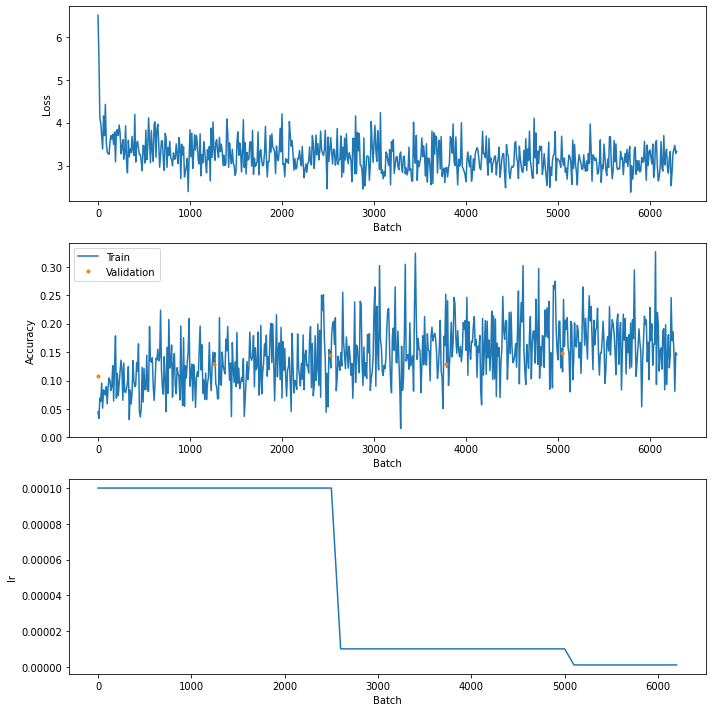

In [12]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
axs = axs.flatten()
batch_iterations = np.arange(0, len(train_dl)*NUM_EPOCHS+1, 10)
axs[0].plot(batch_iterations, running_loss)
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

axs[1].plot(batch_iterations, running_semantic_accuracy, label='Train')
axs[1].plot(batch_iterations[0:-1:int(np.ceil(len(train_dl)/10))], val_accuracy, '.', label='Validation')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(batch_iterations[:-1:10], np.array(lr_monitor).squeeze()[0:-1:10])
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('lr')

#axs[3].plot(batch_iterations[:-1], val_accuracy)
#axs[3].set_xlabel('Batch')
#axs[3].set_ylabel('lr')

fig.tight_layout() 



In [303]:
#acc, best_batch = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=True)
best_k = get_k_best(encoder, decoder, val_dl, 6, device)
#plt.figure()
#plt.imshow(batch['image'][0])

6
(0) Generated: <|endoftext|>A clock tower with a large white tile building above and a dark staircase leading up the steep steps.
   Real: A tan building with ornate clocks on top.  Accuracy: 0.6441400051116943
(1) Generated: <|endoftext|>A giraffe is in a herd of goats in an open field.
   Real: A giraffe is standing in the tall brush.  Accuracy: 0.5166416168212891
(2) Generated: <|endoftext|>The back of a bathroom window looking right out of a pink bathroom mirror.
   Real: An all white bathroom with sink, shower, and toilet.  Accuracy: 0.5028465390205383
(3) Generated: <|endoftext|>A car passed a train with it's lights on.
   Real: a long green train on some metal tracks  Accuracy: 0.4865855872631073
(4) Generated: <|endoftext|>a large carriage brings the  train to a stop.
   Real: Two trains are driving side by side on tracks.  Accuracy: 0.4788283705711365
(5) Generated: <|endoftext|>A plane is approaching a runway.
   Real: A Fed Ex plane flying in a clear blue sky.   Accuracy: 

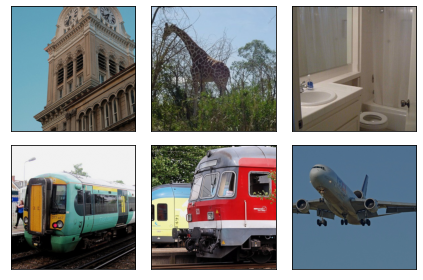

In [314]:
print(len(best_k))
print_batch(best_k, fontsize=10, num_of_columns=3, caption_as_title=False)
